In [1]:
# Import the optimized functions
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from functools import partial


# Set up multiprocessing to use 'spawn' method (more stable)
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

In [2]:
from matrix_processor import process_matrices_parallel

In [3]:
def analyze_multiple_systems_parallel(system_dirs: Dict[str, str], 
                                    n_modes: int = 10,
                                    use_long_chains: bool = False,
                                    source_ranges: Dict[str, List[Tuple[int, int]]] = None,
                                    target_ranges: List[Tuple[int, int]] = None,
                                    max_files: int = None,
                                    n_processes: int = None) -> Dict:
    """
    Analyze multiple systems in parallel.
    
    Args:
        system_dirs: Dictionary mapping system names to directory paths
        n_modes: Number of modes to extract
        use_long_chains: Whether to extract from longer chains
        *source_ranges: Dictionary mapping system names to source ranges
        target_ranges: Target residue ranges (same for all systems)
        max_files: Maximum number of files to analyze per system (for testing)
        n_processes: Number of processes to use
        
        *this is an extra bit of data processing needed to cleanly compare eigenvalues.
        *the apo and onpf-bound version of this system have 1 additional residue in chain A
        *and three additional residues in chain B as compared to iptg-bound. We must first
        *process the full-system covariance matrices into normal modes, then trim the normal
        *modes themselves, accordingly. 
        
    Returns:
        Dictionary with system results
    """
    systems_data = {}
    
    for system_name, directory in system_dirs.items():
        print(f"\nProcessing system: {system_name} from {directory}")
        
        # Get file paths
        dat_files = glob.glob(os.path.join(directory, "*.dat"))
        
        if max_files is not None:
            dat_files = dat_files[:max_files]
        
        print(f"Found {len(dat_files)} matrices")
        
        if not dat_files:
            print(f"No matrices found for {system_name}. Skipping.")
            continue
        
        # Process with chain mapping if needed
        if use_long_chains:
            if source_ranges is None or system_name not in source_ranges or target_ranges is None:
                print(f"Missing range information for {system_name}. Skipping.")
                continue
                
            system_source_ranges = source_ranges[system_name]
            
            # Process with chain mapping and error statistics
            results = process_matrices_parallel(
                dat_files, 
                n_modes=n_modes, 
                use_long_chains=True,
                source_ranges=system_source_ranges,
                target_ranges=target_ranges,
                n_processes=n_processes
            )
        else:
            # Process without chain mapping but with error statistics
            results = process_matrices_parallel(
                dat_files, 
                n_modes=n_modes, 
                use_long_chains=False,
                n_processes=n_processes
            )
        
        systems_data[system_name] = results
        print(f"Processed system {system_name} with {results['n_samples']} samples")
    
    print(f"\nAll systems processed. Ready for comparison.")
    return systems_data

In [4]:
## Fancy plots
import matplotlib as mpl

plt.rcParams['font.family'] = 'serif'

# Use LaTeX for rendering
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set the font sizes and styles
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['mathtext.fontset'] = 'cm'

# Customize the tick parameters
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.minor.size'] = 6
plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.minor.size'] = 6

# Adjust the axis line width
plt.rcParams['axes.linewidth'] = 1.0

# Customize the legend
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handlelength'] = 1.5

In [5]:
# Define system directories and ranges
system_dirs = {
    'apo': './apo',  
    'IPTG': './IPTG', 
    'ONPF': './ONPF'
}

# Numbering ranges below are necessary to correctly calculate normal modes for each system, and then map
# back onto residue IDs 2-328, chains A and B 

# Source ranges for each system (with non-overlapping residue numbers)
source_ranges = {
    'apo': [(2, 329), (330, 659)],           
    'IPTG': [(2, 328), (329, 655)],    
    'ONPF': [(2, 329), (330, 659)]      
}

# Standard ranges for all systems (target, also non-overlapping)
standard_ranges = [(2, 328), (329, 655)]

# 1. Analyze all systems
# Updated function call for multiple systems
all_systems = analyze_multiple_systems_parallel(
    system_dirs,
    n_modes=10,
    use_long_chains=True,
    source_ranges=source_ranges,
    target_ranges=standard_ranges,
    max_files=None,  # Limit files per system for testing, set to None for all
    n_processes=None  # Use all available CPU cores
)


Processing system: apo from ./apo
Found 71 matrices
Processing 71 files using 48 processes...
Processed system apo with 71 samples

Processing system: IPTG from ./IPTG
Found 71 matrices
Processing 71 files using 48 processes...
Processed system IPTG with 71 samples

Processing system: ONPF from ./ONPF
Found 71 matrices
Processing 71 files using 48 processes...
Processed system ONPF with 71 samples

All systems processed. Ready for comparison.


### Create .nmd files for ProDy (requires 1efa_CA.pdb residues 2-328 chains A and B)

In [6]:
import numpy as np

def create_combined_output(pdb_file, eigenvector_file=None, output_file='onpf_normalmodes.nmd'):
    # Read PDB data
    atomnames = []
    resnames = []
    resids = []
    chainids = []
    bfactors = []
    coords = []
    
    with open(pdb_file, 'r') as f:
        for line in f:
            if line.startswith('ATOM') and line[12:16].strip() == 'CA':
                atomnames.append(line[12:16].strip())
                resnames.append(line[17:20].strip())
                resids.append(int(line[22:26].strip()))
                chainids.append(line[21])
                bfactors.append(float(line[60:66].strip()))
                coords.append(float(line[30:38].strip()))
                coords.append(float(line[38:46].strip()))
                coords.append(float(line[46:54].strip()))
    
    # Get eigenvectors
    if eigenvector_file:
        # Load from file if provided
        eigenvectors = np.loadtxt(eigenvector_file)
    else:
        # Use the provided array
        eigenvectors = all_systems['ONPF']['eigenvectors']
    
    # Write combined output
    with open(output_file, 'w') as f:
        f.write("atomnames " + " ".join(atomnames) + "\n")
        f.write("resnames " + " ".join(resnames) + "\n")
        f.write("resids " + " ".join(map(str, resids)) + "\n")
        f.write("chainids " + " ".join(chainids) + "\n")
        f.write("bfactors " + " ".join([f"{bf:.2f}" for bf in bfactors]) + "\n")
        f.write("coordinates " + " ".join([f"{c:.3f}" for c in coords]) + "\n")
        
        # Add modes
        for i in range(eigenvectors.shape[1]):
            f.write(f"mode {i+1} ")
            # You might want to add eigenvalues here - this is a placeholder
            f.write(f"{5.08 - i*0.55:.2f} ")  
            # Format each value in the mode
            for val in eigenvectors[:, i]:
                f.write(f"{val:.3f} ")
            f.write("\n")
    
    print(f"File created: {output_file}")

# Usage
create_combined_output("1efa_CA.pdb")

File created: onpf_normalmodes.nmd


### Created perturbed .pdb files for plotting using modevectors and PyMol

In [7]:
import numpy as np

def create_perturbed_pdb(input_pdb, output_pdb, mode_index, eigenvectors, scale_factor=5.0):
    """
    Apply a normal mode perturbation to a PDB structure.
    
    Parameters:
    -----------
    input_pdb : str
        Path to input PDB file
    output_pdb : str
        Path to output perturbed PDB file
    mode_index : int
        Index of the mode to apply (1-based)
    eigenvectors : numpy.ndarray
        Array of eigenvectors
    scale_factor : float
        Scaling factor for the perturbation
    """
    # Adjust mode_index to 0-based
    mode_idx = mode_index - 1
    
    # Get the selected mode
    mode = eigenvectors[:, mode_idx]
    
    # Read PDB file and apply perturbation
    with open(input_pdb, 'r') as fin, open(output_pdb, 'w') as fout:
        atom_counter = 0
        
        for line in fin:
            if line.startswith('ATOM') or line.startswith('HETATM'):
                # Parse coordinates
                x = float(line[30:38])
                y = float(line[38:46])
                z = float(line[46:54])
                
                if line[12:16].strip() == 'CA':  # Only perturb CA atoms
                    # Get displacement from eigenvector (3 values per atom)
                    idx = atom_counter * 3
                    dx = mode[idx] * scale_factor
                    dy = mode[idx + 1] * scale_factor
                    dz = mode[idx + 2] * scale_factor
                    
                    # Apply perturbation
                    x += dx
                    y += dy
                    z += dz
                    
                    atom_counter += 1
                
                # Create new line with perturbed coordinates
                new_line = line[:30] + f"{x:8.3f}{y:8.3f}{z:8.3f}" + line[54:]
                fout.write(new_line)
            else:
                fout.write(line)
    
    print(f"Created perturbed PDB file: {output_pdb}")

# Usage
create_perturbed_pdb("1efa_CA.pdb", "onpf_mode3.pdb", 3, all_systems['ONPF']['eigenvectors'], scale_factor=100.0)

Created perturbed PDB file: onpf_mode3.pdb


In [8]:
def compare_eigenvalues(systems_data: Dict[str, Dict], n_modes: int = 10, savefig: str = None):
    """
    Compare eigenvalues across different systems with error bars.
    
    Args:
        systems_data: Dictionary with system names as keys and results as values
        n_modes: Number of modes to compare
    """
    # Define system colors
    colors = {'apo': 'black', 'IPTG': 'orange', 'ONPF': 'purple'}
    
    # Define the preferred order
    preferred_order = ['ONPF', 'apo', 'IPTG']
    
    # Get available systems and sort them according to preferred order
    available_systems = list(systems_data.keys())
    systems = []
    
    # First add systems in preferred order (if present)
    for sys in preferred_order:
        if sys in available_systems:
            systems.append(sys)
    
    # Then add any remaining systems
    for sys in available_systems:
        if sys not in systems:
            systems.append(sys)
    
    # Set up the plot
    plt.figure(figsize=(12, 6))
    
    # Calculate bar width based on number of systems
    width = 0.8 / len(systems)
    
    # Plot bars for each system
    for i, system in enumerate(systems):
        results = systems_data[system]
        
        if 'avg_eigenvalues' in results:
            eigenvalues = results['eigenvalues'][:n_modes]
            errors = results['sem_eigenvalues'][:n_modes] if 'sem_eigenvalues' in results else None
        else:
            eigenvalues = results['eigenvalues'][:n_modes]
            errors = None
        
        # Calculate positions
        x = np.arange(1, n_modes + 1)
        offset = (i - len(systems)/2 + 0.5) * width
        
        # Plot bars with error bars if available
        plt.bar(x + offset, eigenvalues, width=width, 
                color=colors.get(system, 'blue'), 
                yerr=errors, capsize=5,
                label=system, alpha=0.7)
    
    plt.xlabel('Mode Number')
    plt.ylabel('Eigenvalue')
    plt.title('Eigenvalue Comparison Across Systems')
    plt.xticks(np.arange(1, n_modes + 1))
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    
    if savefig:
        plt.savefig(savefig, dpi=800, bbox_inches='tight')
        
    plt.show()


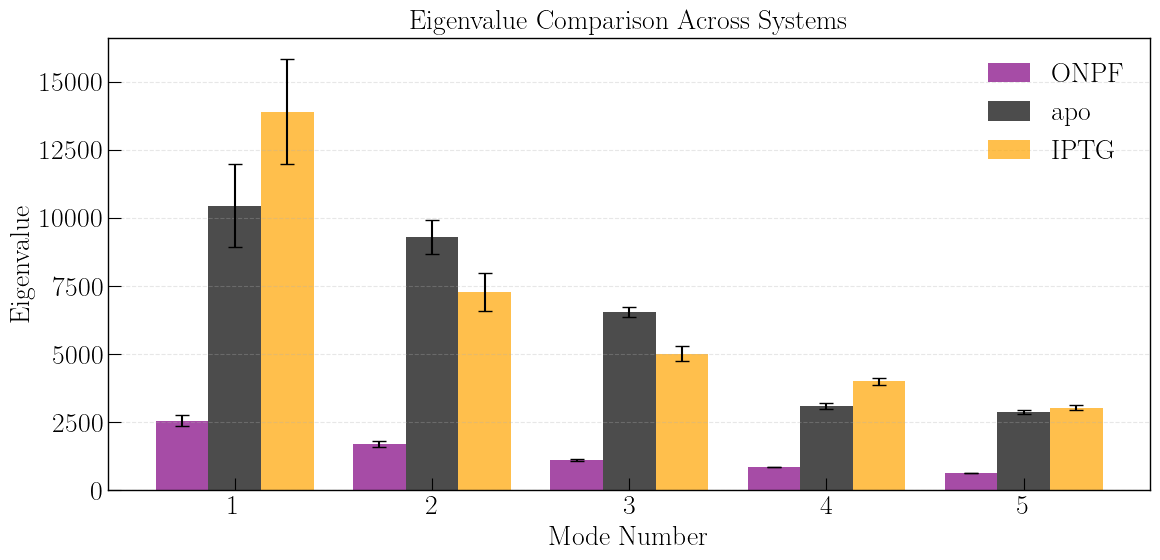

In [9]:
compare_eigenvalues(all_systems, n_modes=5, savefig='Eigenvalue_spectrum_n5.png')


In [10]:
def compare_residue_contributions(systems_data: Dict[str, Dict], 
                                residue_range: Tuple[int, int] = None,
                                mode: int = 0,
                                flip_chains_for: List[str] = ['ONPF'], 
                                average_chains: bool = False,
                                show_boxplots: bool = False,
                                savefig: str = None):
    """
    Compare contributions of a range of residues across different systems.
    
    Args:
        systems_data: Dictionary with system names as keys and results as values
        residue_range: Tuple of (start, end) residue indices to plot
        mode: Mode number to compare (0-based)
        flip_chains_for: List of system names for which to flip chains A and B
        average_chains: Whether to show pairwise position averages across chains
        show_boxplots: Whether to add boxplots to the right side of the plot
    """
    # Define system colors and markers
    colors = {'apo': 'black', 'IPTG': 'orange', 'ONPF': 'purple'}
    markers = {'apo': 'o', 'IPTG': 's', 'ONPF': '^'}
    
    # Define the preferred order
    preferred_order = ['ONPF', 'apo', 'IPTG']
    
    # Get available systems and sort them according to preferred order
    available_systems = list(systems_data.keys())
    systems = []
    
    # First add systems in preferred order (if present)
    for sys in preferred_order:
        if sys in available_systems:
            systems.append(sys)
    
    # Then add any remaining systems
    for sys in available_systems:
        if sys not in systems:
            systems.append(sys)
    
    # First, get all available labels
    reference_system = systems[0]
    all_labels = systems_data[reference_system]['labels']
    
    # Find the chain boundary (where B chain starts)
    try:
        chain_boundary = all_labels.index('B2')
    except ValueError:
        # If 'B2' not found, estimate halfway point
        chain_boundary = len(all_labels) // 2
    
    # Create figure with GridSpec for main plot and optional boxplots
    if show_boxplots:
        from matplotlib.gridspec import GridSpec
        fig = plt.figure(figsize=(16, 8))
        gs = GridSpec(1, 2, width_ratios=[3, 1])
        main_ax = fig.add_subplot(gs[0, 0])
        box_ax = fig.add_subplot(gs[0, 1])
    else:
        fig, main_ax = plt.subplots(figsize=(14, 6))
    
    # Determine residue range to plot
    if residue_range is None:
        # Default to plotting all residues
        start_idx, end_idx = 0, len(all_labels)
    else:
        # Find indices corresponding to the requested residue range
        start_res, end_res = residue_range
        
        # Extract residue numbers from labels (strip chain ID)
        residue_numbers = [int(label[1:]) if len(label) > 1 else 0 for label in all_labels]
        
        # Find indices of residues in the specified range
        in_range_indices = [i for i, res in enumerate(residue_numbers) 
                          if start_res <= res <= end_res]
        
        if in_range_indices:
            start_idx, end_idx = min(in_range_indices), max(in_range_indices) + 1
        else:
            start_idx, end_idx = 0, len(all_labels)
            print(f"Warning: No residues found in range {start_res}-{end_res}")
    
    # Get x-axis labels (residue numbers)
    x_labels = all_labels[start_idx:end_idx]
    x = np.arange(len(x_labels))
    
    # Store values for boxplot
    boxplot_data = []
    boxplot_labels = []
    
    # Plot each system
    for system in systems:
        results = systems_data[system]
        
        # Use average magnitudes if available, otherwise use direct values
        if 'avg_magnitudes' in results:
            magnitudes = results['magnitudes']
            errors = results['sem_magnitudes'] if 'sem_magnitudes' in results else None
        else:
            magnitudes = results['magnitudes']
            errors = None
        
        # Flip chains if requested for this system
        if flip_chains_for and system in flip_chains_for:
            # Create flipped version by concatenating B chain first, then A chain
            b_chain = magnitudes[chain_boundary:, :]
            a_chain = magnitudes[:chain_boundary, :]
            magnitudes = np.vstack((b_chain, a_chain))
            
            if errors is not None:
                b_errors = errors[chain_boundary:, :]
                a_errors = errors[:chain_boundary, :]
                errors = np.vstack((b_errors, a_errors))
        
        # Get values for the selected mode
        mode_values = magnitudes[start_idx:end_idx, mode]
        mode_errors = errors[start_idx:end_idx, mode] if errors is not None else None
        
        # Average chains if requested
        if average_chains:
            # Find corresponding positions in A and B chains
            positions = len(x_labels)
            half_positions = positions // 2
            
            # Calculate average for corresponding A and B positions
            averaged_values = []
            averaged_errors = [] if mode_errors is not None else None
            averaged_x = []
            averaged_labels = []
            
            for i in range(half_positions):
                if i < len(mode_values) and i + half_positions < len(mode_values):
                    pos_a = mode_values[i]
                    pos_b = mode_values[i + half_positions]
                    avg_val = (pos_a + pos_b) / 2
                    averaged_values.append(avg_val)
                    averaged_x.append(i)
                    averaged_labels.append(f"{i+1}")
                    
                    if mode_errors is not None:
                        err_a = mode_errors[i]
                        err_b = mode_errors[i + half_positions]
                        avg_err = np.sqrt(err_a**2 + err_b**2) / 2  # Propagate error
                        averaged_errors.append(avg_err)
            
            # Replace with averaged data
            mode_values = np.array(averaged_values)  # Convert to numpy arrays
            mode_errors = np.array(averaged_errors) if averaged_errors else None
            x = np.array(averaged_x)
            x_labels = averaged_labels
        
        # Plot as scatter points
        main_ax.scatter(x, mode_values, 
                      color=colors.get(system, 'blue'),
                      marker=markers.get(system, 'o'),
                      s=50, alpha=0.7, label=system)
        
        # Add error bands if available
        if mode_errors is not None:
            # Ensure we're working with numpy arrays
            if not isinstance(mode_values, np.ndarray):
                mode_values = np.array(mode_values)
            if not isinstance(mode_errors, np.ndarray):
                mode_errors = np.array(mode_errors)
                
            main_ax.fill_between(x, 
                               mode_values - mode_errors,
                               mode_values + mode_errors,
                               color=colors.get(system, 'blue'),
                               alpha=0.2)
        
        # Store data for boxplot
        if show_boxplots:
            boxplot_data.append(mode_values)
            boxplot_labels.append(system)
    
    # Add vertical lines to separate chains if not averaging
    if not average_chains:
        chain_boundaries = []
        if len(x_labels) > 0:
            current_chain = x_labels[0][0] if len(x_labels[0]) > 0 else 'A'  # First character is chain ID
            for i, label in enumerate(x_labels):
                if len(label) > 0 and label[0] != current_chain:
                    chain_boundaries.append(i)
                    current_chain = label[0]
        
        for boundary in chain_boundaries:
            main_ax.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5)
    
    # Set x-axis labels
    if len(x_labels) > 50:
        # If too many labels, show fewer
        step = len(x_labels) // 20
        main_ax.set_xticks(x[::step])
        main_ax.set_xticklabels(x_labels[::step], rotation=90)
    else:
        main_ax.set_xticks(x)
        main_ax.set_xticklabels(x_labels, rotation=90)
    
    main_ax.set_xlabel('Residue', fontsize=12)
    main_ax.set_ylabel('Eigenvector Magnitude', fontsize=12)
    chain_text = "Pairwise Position Averages" if average_chains else "Residue Contributions"
    range_text = f" (Residues {residue_range[0]}-{residue_range[1]})" if residue_range else ""
    main_ax.set_title(f'Mode {mode+1} {chain_text}', fontsize=14)
    main_ax.legend()
    main_ax.grid(alpha=0.3)
    
    # Create boxplot if requested
    if show_boxplots and boxplot_data:
        # Get original order for systems
        ordered_data = []
        ordered_colors = []
        
        # Reorder data according to preferred order
        for system in preferred_order:
            if system in boxplot_labels:
                idx = boxplot_labels.index(system)
                ordered_data.append(boxplot_data[idx])
                ordered_colors.append(colors.get(system, 'blue'))
        
        # Create boxplot
        bp = box_ax.boxplot(
            ordered_data,
            patch_artist=True,
            medianprops=dict(color="white", linewidth=1.5),
            flierprops=dict(marker='o', markerfacecolor='white', 
                          markeredgecolor='gray', markersize=4)
        )
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], ordered_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        # Set boxplot labels
        box_ax.set_xticklabels(preferred_order, rotation=45)
        box_ax.set_ylabel('Eigenvector Magnitude')
        box_ax.set_title('Distribution Summary')
        
        # Match y-axis limits between main plot and boxplot
        y_min, y_max = main_ax.get_ylim()
        box_ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    
    if savefig:
        plt.savefig(savefig, dpi=800, bbox_inches='tight')
    
    plt.show()

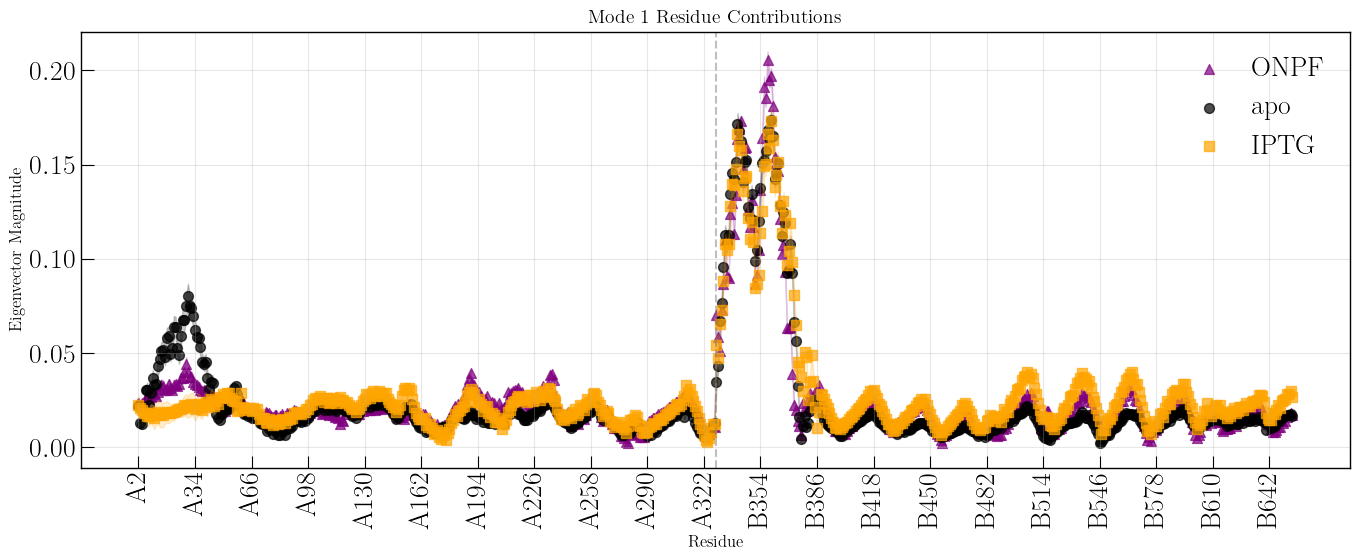

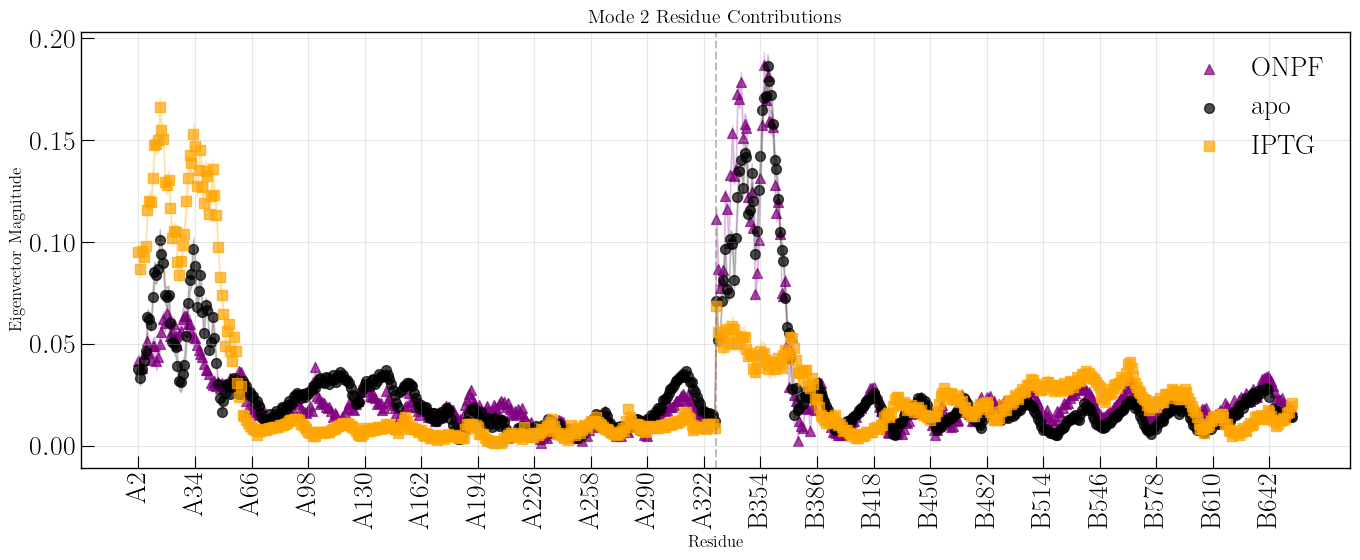

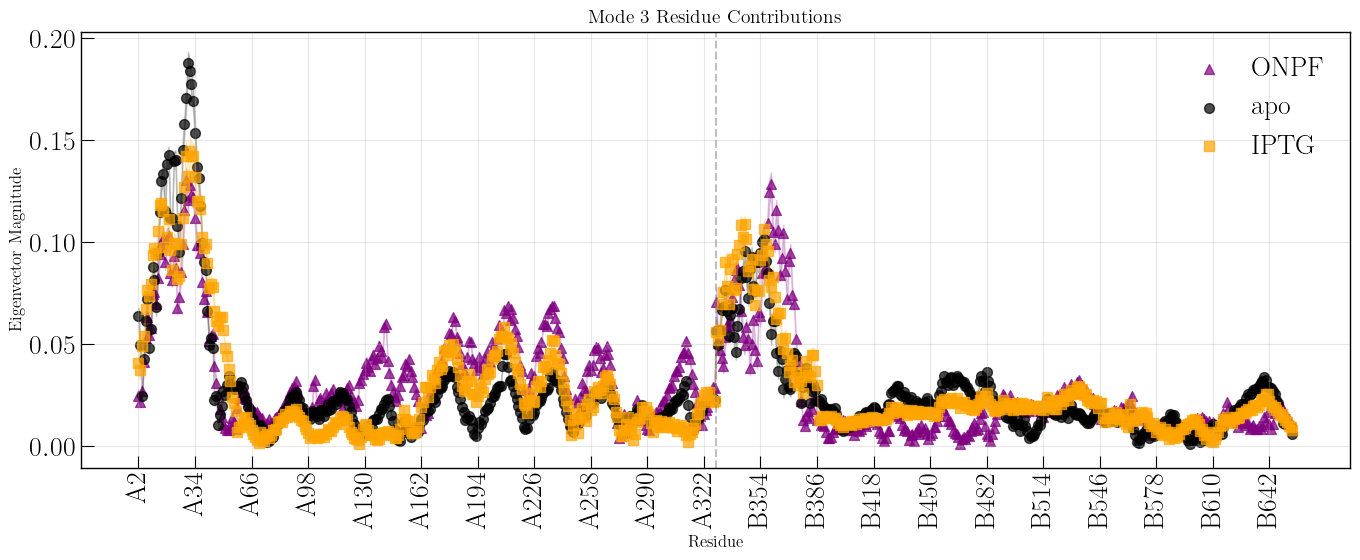

In [11]:
for i in range(0, 3):
    # 2,655 covers entire 2-328 chain A + chain B set of residues (note that range of 655 gets accounted for in the plotting code)
    compare_residue_contributions(all_systems, residue_range=(2, 655), mode=i, savefig=f"per_residue_contribution_mode{i}.png")




In [12]:
def plot_eigenvector_heatmap(results: dict,
                             n_modes: int = 5,
                             vmin: float = None,
                             vmax: float = None,
                             flip_chains: bool = False,
                             system_name: str = None,
                             renumber_chains: bool = True,
                             savefig: str = None):
    """
    Plot heatmap of eigenvector magnitudes for the first n_modes.
    Args:
        results: Results dictionary with keys:
                 - 'magnitudes': numpy array of shape (n_residues, n_modes)
                 - 'labels': list of residue labels
        n_modes: Number of modes to plot
        vmin: Minimum value for colormap
        vmax: Maximum value for colormap
        flip_chains: Whether to flip chains A and B
        system_name: Name of the system being plotted (auto-flips for 'ONPF')
        renumber_chains: Whether to renumber Chain B to start from B2 instead of B329
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Auto-flip for ONPF if system_name is provided
    if system_name == 'ONPF' and not flip_chains:
        flip_chains = True
        
    magnitudes = results['magnitudes'][:, :n_modes]
    labels = results['labels'].copy()  # Create a copy to avoid modifying the original
    
    # Find the chain boundary (where chain B starts)
    try:
        chain_boundary = labels.index('B2')
    except ValueError:
        # Check if we have labels that start with 'B'
        b_indices = [i for i, label in enumerate(labels) if label.startswith('B')]
        if b_indices:
            chain_boundary = b_indices[0]
        else:
            # If 'B2' is not found, use half of the residues as a rough boundary
            chain_boundary = len(labels) // 2
    
    # Renumber Chain B residues if needed
    if renumber_chains:
        # Get the current Chain B labels
        b_chain_labels = labels[chain_boundary:]
        
        # Create new B chain labels that start from B2, B3, etc.
        new_b_labels = []
        for i, label in enumerate(b_chain_labels):
            if label.startswith('B'):
                # Extract just the residue number
                try:
                    res_num = int(label[1:])
                    # Calculate the new residue number (starting from 2)
                    new_res_num = i + 2
                    new_b_labels.append(f'B{new_res_num}')
                except ValueError:
                    # If we can't convert to int, keep the original
                    new_b_labels.append(label)
            else:
                # For non-B chain labels, just use index-based numbering
                new_b_labels.append(f'B{i+2}')
        
        # Replace the B chain labels
        labels[chain_boundary:] = new_b_labels
    
    # Flip chains if requested
    if flip_chains:
        b_chain = magnitudes[chain_boundary:, :]
        a_chain = magnitudes[:chain_boundary, :]
        magnitudes = np.vstack((b_chain, a_chain))
        b_labels = labels[chain_boundary:]
        a_labels = labels[:chain_boundary]
        labels = b_labels + a_labels
    
    # Create a heatmap
    plt.figure(figsize=(12, 6))
    im = plt.imshow(
        magnitudes,
        aspect='auto',
        cmap='viridis',   # Default colormap
        interpolation='nearest',
        vmin=vmin,
        vmax=vmax
    )
    plt.colorbar(im, label='Eigenvector Magnitude')
    
    # Set x-axis (modes)
    plt.xticks(np.arange(n_modes), [f'Mode {i+1}' for i in range(n_modes)])
    
    # Set y-axis (residues) - show fewer labels if there are many residues
    n_residues = len(labels)
    if n_residues > 60:
        step = max(1, n_residues // 20)
        positions = np.arange(0, n_residues, step)
        labels_to_show = [labels[i] for i in positions]
        plt.yticks(positions, labels_to_show)
    else:
        plt.yticks(np.arange(n_residues), labels)
    
    # Add horizontal line to mark the chain boundary
    if not flip_chains:
        boundary_y = chain_boundary - 0.5
    else:
        boundary_y = len(labels) - chain_boundary - 0.5
    plt.axhline(y=boundary_y, color='red', linestyle='--', linewidth=2)
    
    plt.ylabel('Residue')
    chain_text = "" if flip_chains else ""
    system_text = f"{system_name}" if system_name else ""
    plt.title(f'{system_text}{chain_text}')
    plt.tight_layout()
    
    if savefig:
        plt.savefig(savefig, dpi=800, bbox_inches='tight')
    
    plt.show()
    
    return labels  # Return the (potentially modified) labels for verification

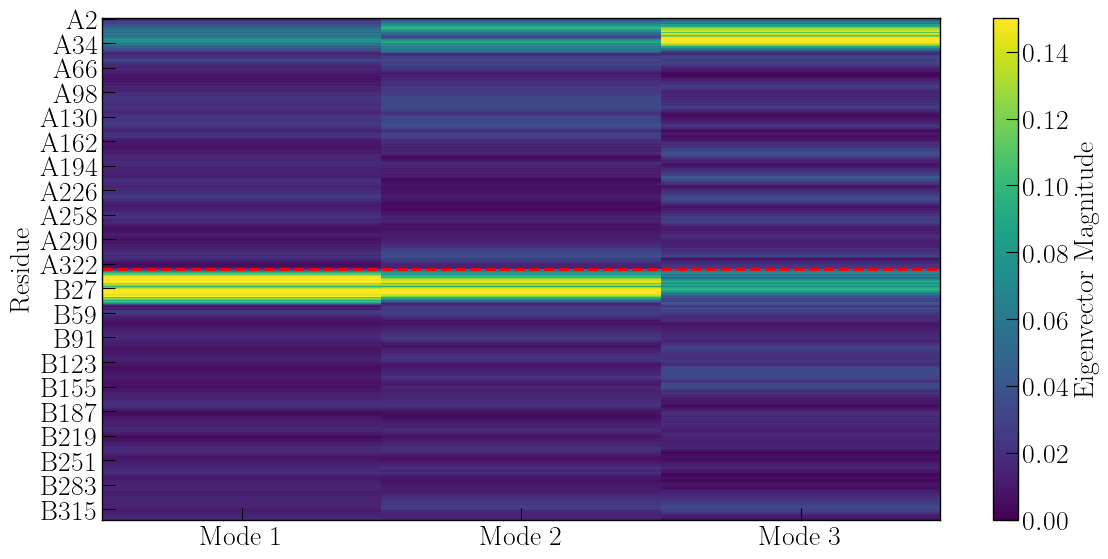

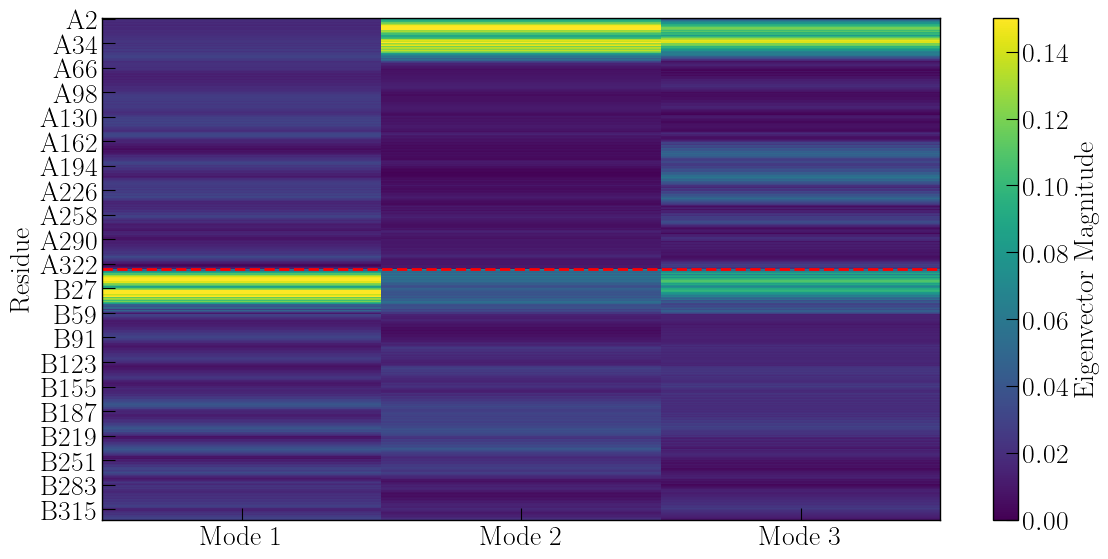

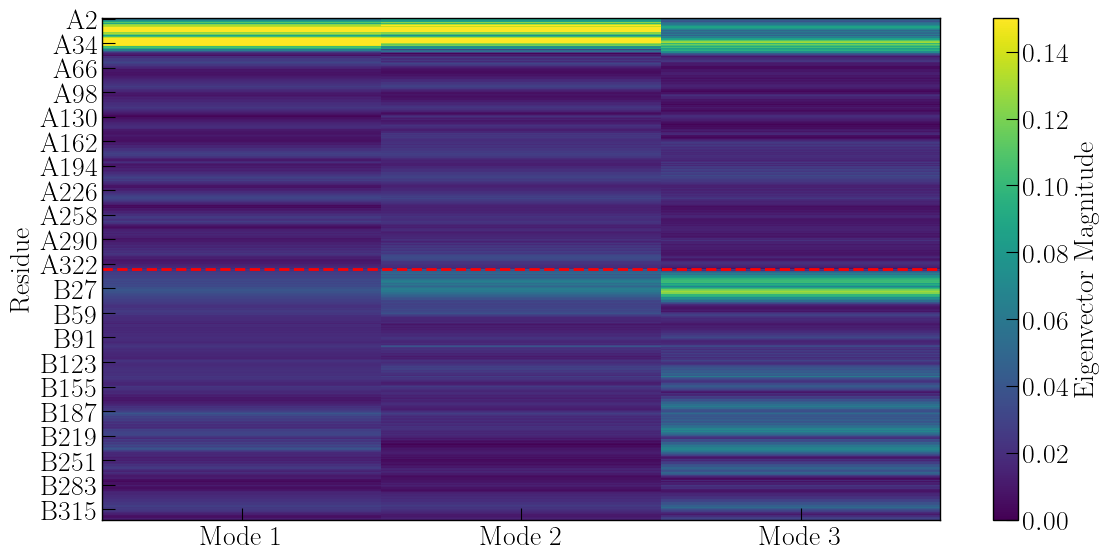

In [13]:
# 4. Create heatmaps for each system individually
for system, results in all_systems.items():
    plot_eigenvector_heatmap(results, n_modes=3, vmin=0, vmax=0.15, savefig='normal_modes3_heatmap.png')

